### Imports

In [1]:
# IMPORT PACKAGE
import os
import cv2
import math
import random
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output
from random import randint
from glob import glob
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import Sequence
import albumentations as A
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, ReLU, Add, Softmax, Dropout, LeakyReLU, UpSampling2D, concatenate, ZeroPadding2D, Activation, Input, LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.regularizers import l2
from skmultilearn.model_selection import iterative_train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
#from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.mixed_precision import Policy, set_global_policy
from tensorflow.keras.layers import Input, Dense, Conv2D, GlobalAveragePooling2D, Lambda, Reshape, Dropout, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, UpSampling2D, multiply, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.mixed_precision import Policy, set_global_policy
clear_output()

In [2]:
# GPU MEMORY GROWTH
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set for GPUs.")
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")
# ENCODE AND DECODE METHOD  

Memory growth set for GPUs.


In [3]:
mask_rgb_values = {
    'Forest': [0, 255, 0],
    'Agricultural Land': [165, 42, 42],
    'Road': [70, 130, 180],
    'Grassland': [50, 205, 50],
    'Water Bodies': [0, 0, 255],
    'Shrubland': [173, 255, 47],
    'Built-up': [255, 105, 45],
    'Unlabelled': [0, 0, 0],
}

def encode_categorical(mask, num_classes=8):
    cat_encoded = np.zeros((mask.shape[0], mask.shape[1], num_classes), dtype='float32')
    for i, value in enumerate(mask_rgb_values.values()):
        condition = np.all(mask == value, axis=-1)
        cat_encoded[condition, i] = 1.0
    return cat_encoded


def decode_prediction(pred, num_classes=8):
  argmax_idx = np.array([np.argmax(x) for x in pred.reshape((-1, num_classes))])
  argmax_idx = argmax_idx.reshape(pred.shape[:-1])

  decoded_mask=np.zeros(shape=(*pred.shape[:-1], 3), dtype='uint8')

  for i, value in enumerate(mask_rgb_values.values()):
    decoded_mask[argmax_idx==i] = value
  return decoded_mask  

In [4]:
  
# CUSTOM DATA GENERATOR  
  
class ImageDataGenerator(Sequence):
    def __init__(self,
                 img_paths,
                 mask_paths,
                 batch_size,
                 augment,
                 num_classes=8,
                 shuffle=False):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.augment = augment

        self.indexes = np.arange(len(self.img_paths))
        self.on_epoch_end()
        
    def __len__(self):
        return math.ceil(len(self.img_paths) / self.batch_size)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        # Get batch indexes
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_img_paths = [self.img_paths[i] for i in batch_indexes]
        batch_mask_paths = [self.mask_paths[i] for i in batch_indexes]

        # Load and preprocess batch
        X, y = self.__load_batch(batch_img_paths, batch_mask_paths)
        return X, y
    
    def __load_batch(self, batch_img_paths, batch_mask_paths):
        batch_img = []
        batch_mask = []

        for img_path, mask_path in zip(batch_img_paths, batch_mask_paths):
            # Load image and mask
            image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)

            # Encode mask as categorical
            mask = encode_categorical(mask, num_classes=self.num_classes)
            
            # Perform augmentation if enabled
            if self.augment:
                augmented_images, augmented_masks = self.data_augmentation(image, mask)
                batch_img.extend(augmented_images)
                batch_mask.extend(augmented_masks)
            else:
                batch_img.append(image.astype(np.float32) / 255.0)
                batch_mask.append(mask.astype(np.float32))

        return np.array(batch_img, dtype='float32'), np.array(batch_mask, dtype='float32')   

    def data_augmentation(self, image, mask):
        transform = A.Compose([
            A.RandomBrightnessContrast(p=0.2),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
        ])

        augmented = transform(image=image, mask=mask)
        augmented_image = augmented['image']
        augmented_mask = augmented['mask']

        original_image = image.astype(np.float32) / 255.0
        original_mask = mask.astype(np.float32) 
        augmented_image = augmented_image.astype(np.float32) / 255.0
        augmented_mask = augmented_mask.astype(np.float32)

        return [original_image, augmented_image], [original_mask, augmented_mask]    

In [5]:

# Load CSVs
train_df = pd.read_csv('/home/rdadmin/Tsiyon/notebook/SPLITS/train.csv')
val_df = pd.read_csv('/home/rdadmin/Tsiyon/notebook/SPLITS/val.csv')
test_df = pd.read_csv('/home/rdadmin/Tsiyon/notebook/SPLITS/test.csv')

# Extract paths from the CSVs
train_img_paths = train_df['image_path'].tolist()
train_mask_paths = train_df['mask_path'].tolist()

val_img_paths = val_df['image_path'].tolist()
val_mask_paths = val_df['mask_path'].tolist()

test_img_paths = test_df['image_path'].tolist()
test_mask_paths = test_df['mask_path'].tolist()

In [6]:
# METRICS
def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def combined_dice_crossentropy_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    crossentropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return dice + crossentropy


class MeanIoUWrapper(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='iou_metric', **kwargs):
        super(MeanIoUWrapper, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.iou_metric = MeanIoU(num_classes=num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        self.iou_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return self.iou_metric.result()

    def reset_states(self):
        self.iou_metric.reset_states()

def iou_metric(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.cast(tf.argmax(y_true, axis=-1), tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-6)  
    
def dice_coef_metric(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    
def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)
input_shape = (256, 256, 3)
n_classes = 8

In [7]:



# MODEL DEFINITION
from tensorflow.keras.applications import Xception 
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding='same', use_bias=False):
    x = Conv2D(
        num_filters, 
        kernel_size=kernel_size, 
        dilation_rate=dilation_rate, 
        padding=padding, 
        use_bias=use_bias, 
        #kernel_initializer='he_normal',
        #kernel_regularizer=l2(0.1)  # Added L2 regularization
    )(block_input)
    x = BatchNormalization()(x)  # Added Batch Normalization
    x = Dropout(0.3)(x)
    return Activation('relu')(x)

def DilatedSpatialPyramidPooling(input):
    dims = input.shape
    x = Conv2D(256, (1, 1), padding='same', use_bias=False)(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    atrous_block1 = Conv2D(256, (3, 3), padding='same', dilation_rate=(1, 1), use_bias=False)(input)
    atrous_block1 = BatchNormalization()(atrous_block1)
    atrous_block1 = ReLU()(atrous_block1)

    atrous_block6 = Conv2D(256, (3, 3), padding='same', dilation_rate=(6, 6), use_bias=False)(input)
    atrous_block6 = BatchNormalization()(atrous_block6)
    atrous_block6 = ReLU()(atrous_block6)

    atrous_block12 = Conv2D(256, (3, 3), padding='same', dilation_rate=(12, 12), use_bias=False)(input)
    atrous_block12 = BatchNormalization()(atrous_block12)
    atrous_block12 = ReLU()(atrous_block12)

    atrous_block18 = Conv2D(256, (3, 3), padding='same', dilation_rate=(18, 18), use_bias=False)(input)
    atrous_block18 = BatchNormalization()(atrous_block18)
    atrous_block18 = ReLU()(atrous_block18)

    pooling = AveragePooling2D(pool_size=(dims[-3], dims[-2]))(input)
    pooling = Conv2D(256, (1, 1), padding='same', use_bias=False)(pooling)
    pooling = BatchNormalization()(pooling)
    pooling = ReLU()(pooling)
    pooling = UpSampling2D(size=(dims[-3] // pooling.shape[1], dims[-2] // pooling.shape[2]), interpolation='bilinear')(pooling)

    concat = concatenate([x, atrous_block1, atrous_block6, atrous_block12, atrous_block18, pooling])
    output = Conv2D(256, (1, 1), padding='same', use_bias=False)(concat)
    output = BatchNormalization()(output)
    output = ReLU()(output)

    return output
def DeeplabV3Plus(image_size, num_classes):
    input = Input(shape=(image_size, image_size, 3))
    xception = Xception(weights='imagenet', include_top=False, input_tensor=input)

    x = xception.get_layer('block13_sepconv2_bn').output  # Changed to an appropriate layer in Xception
    x = DilatedSpatialPyramidPooling(x)

    input_a = UpSampling2D(size=(image_size // x.shape[1], image_size // x.shape[2]), interpolation='bilinear')(x)
    input_b = xception.get_layer('block4_sepconv2_bn').output  # Changed to an appropriate layer in Xception
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    # Upsample 'input_b' to match 'input_a' size
    input_b = UpSampling2D(size=(input_a.shape[1] // input_b.shape[1], input_a.shape[2] // input_b.shape[2]), interpolation='bilinear')(input_b)
    x = concatenate([input_a, input_b], axis=-1)

    x = convolution_block(x)
    x = convolution_block(x)
    x = UpSampling2D(size=(image_size // x.shape[1], image_size // x.shape[2]), interpolation='bilinear')(x)
    output = Conv2D(num_classes, kernel_size=(1, 1), padding='same', activation='softmax')(x)
    return Model(inputs=input, outputs=output, name='DeepLabV3')


In [8]:

#MODEL TRAINING
train_generator = ImageDataGenerator(
    img_paths=train_img_paths,
    mask_paths=train_mask_paths,
    batch_size=8,
    augment=True,  # Augmentation is enabled for training
    num_classes=8,
    shuffle=True  # Shuffling enabled for training
)

val_generator = ImageDataGenerator(
    img_paths=val_img_paths,
    mask_paths=val_mask_paths,
    batch_size=8,
    augment=True,  # No augmentation for validation
    num_classes=8,
    shuffle=True  # No shuffling for validation (ensure deterministic behavior)
)

test_generator = ImageDataGenerator(
    img_paths=test_img_paths,
    mask_paths=test_mask_paths,
    batch_size=8,
    augment=True,  # No augmentation for testing
    num_classes=8,
    shuffle=True  # No shuffling for testing (ensure deterministic behavior)
)



In [9]:
from tensorflow.keras.models import Model
# Set mixed precision policy
policy = Policy('mixed_float16')
set_global_policy(policy)
saved_model_path = "/home/rdadmin/Tsiyon/NEWONE/MODELSAVED/DEEPV3XCEPTION.weights.h5"
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = DeeplabV3Plus(image_size=256, num_classes=8)
    adamw_optimizer = Adam(learning_rate=1e-4, weight_decay=1e-5)
    model.load_weights(saved_model_path)
    model.compile(optimizer=adamw_optimizer, 
              loss=combined_dice_crossentropy_loss, 
              metrics=[dice_coef_metric, jacard_coef, MeanIoUWrapper(num_classes=n_classes)])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


I0000 00:00:1742907471.093243  902201 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13770 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:06:00.0, compute capability: 7.5
I0000 00:00:1742907471.095851  902201 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13770 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:07:00.0, compute capability: 7.5


2025-03-25 15:58:03.412475: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-03-25 15:58:03.412716: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2025-03-25 15:58:03.421774: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2025-03-25 15:58:11.712840: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1742907492.062184  902806 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1742907492.288940  902807 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


2025-03-25 15:58:22.256917: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


2025-03-25 15:58:25.327937: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


2025-03-25 15:58:30.700903: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


2025-03-25 15:58:41.438074: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


2025-03-25 15:59:03.526756: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-03-25 15:59:45.331629: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

2025-03-25 16:01:11.187389: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

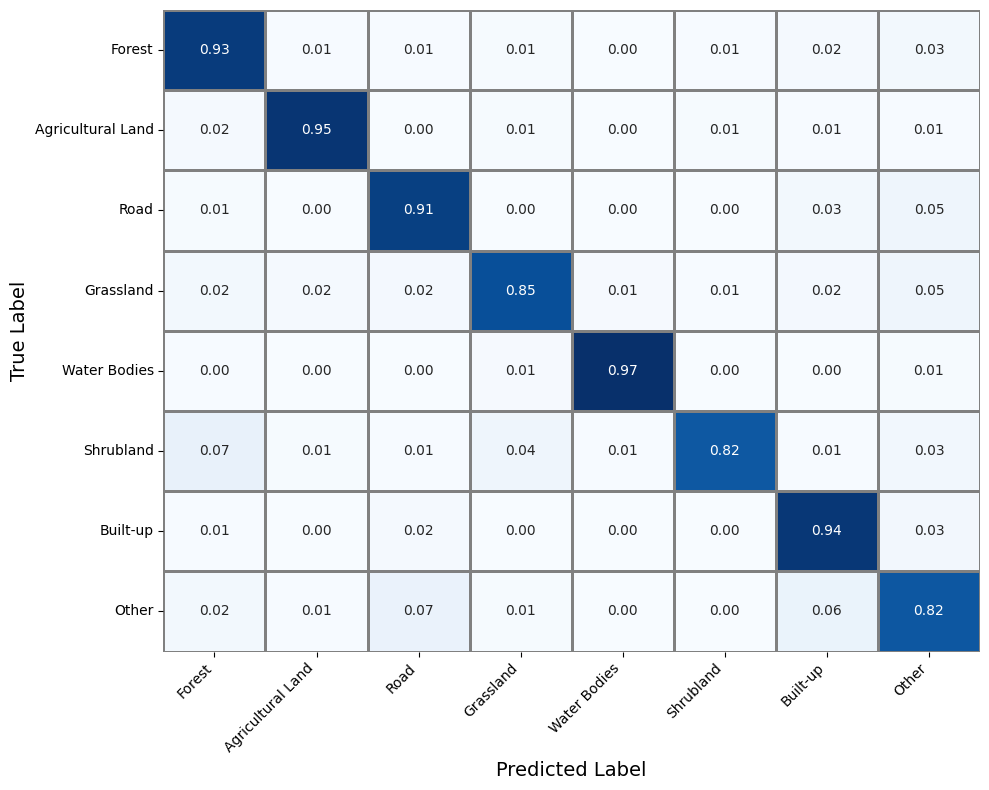

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

total_steps = len(val_generator)  
# Initialize arrays to store predictions and true labels
all_preds = []
all_true = []

# Loop through the test generator to collect predictions and ground truths
for i in range(total_steps):
    # Get the next batch of images and masks from the generator
    batch = val_generator[i]
    imgs, masks = batch[0], batch[1]  # Assuming the generator returns (images, masks)

    preds = model.predict(imgs)  # Predict on the batch
    preds = preds.argmax(axis=-1)  # Convert probabilities to class indices
    masks = masks.argmax(axis=-1)  # Convert one-hot masks to class indices

    all_preds.append(preds)
    all_true.append(masks)

# Convert the lists to numpy arrays and flatten them
y_true_flat = np.concatenate(all_true, axis=None)  # Concatenate and flatten true labels
y_pred_flat = np.concatenate(all_preds, axis=None)  # Concatenate and flatten predictions

# Class labels for the confusion matrix
class_labels = ['Forest', 'Agricultural Land', 'Road', 'Grassland',
                'Water Bodies', 'Shrubland', 'Built-up', 'Other']

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized)  # Handle NaN values

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues',
                 xticklabels=class_labels, yticklabels=class_labels, fmt='.2f', cbar=False,  # Set cbar=False to remove the color bar
                 linewidths=0.722819, linecolor='gray')

# Increase font size of text labels
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

# Make all four borders bold and equal
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Adjust thickness (e.g., 2 for bold)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Add title
plt.title('')

# Save the plot as a file with high quality (300 dpi)
plt.tight_layout()
plt.savefig('/home/rdadmin/Tsiyon/NEWONE/RESULT/DEEPXCP_CM.png', dpi=300)

# Show the plot
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-03-25 16:07:25.218488: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-03-25 16:13:10.808592: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

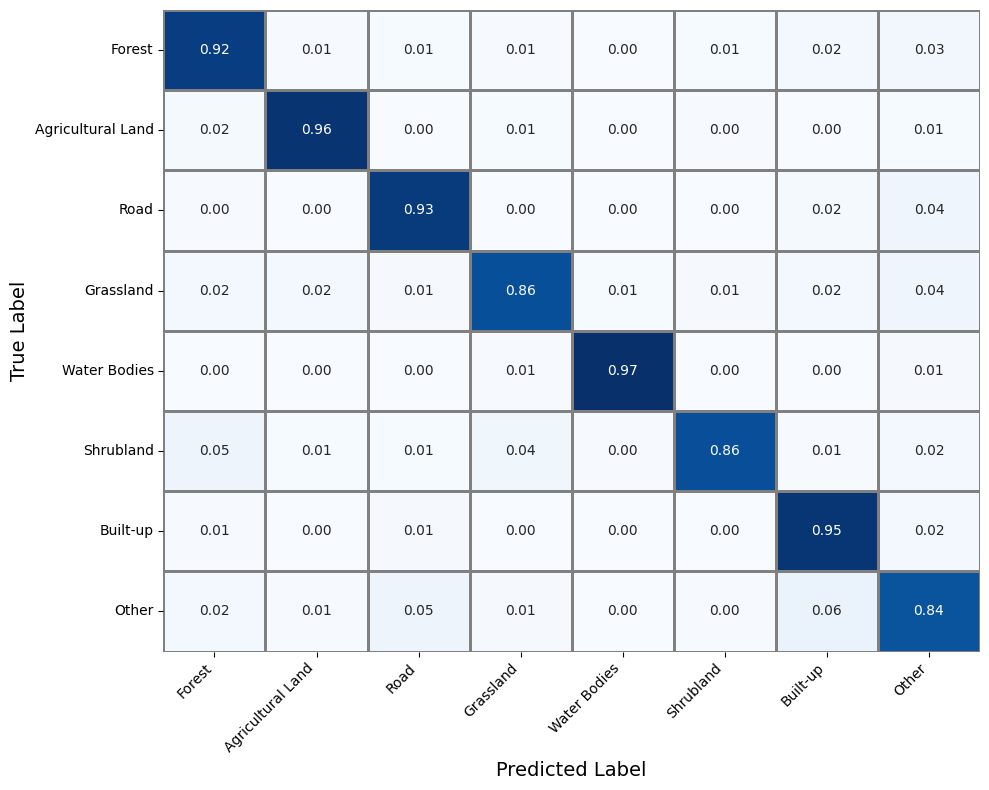

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

total_steps = len(test_generator)  
# Initialize arrays to store predictions and true labels
all_preds = []
all_true = []

# Loop through the test generator to collect predictions and ground truths
for i in range(total_steps):
    # Get the next batch of images and masks from the generator
    batch = test_generator[i]
    imgs, masks = batch[0], batch[1]  # Assuming the generator returns (images, masks)

    preds = model.predict(imgs)  # Predict on the batch
    preds = preds.argmax(axis=-1)  # Convert probabilities to class indices
    masks = masks.argmax(axis=-1)  # Convert one-hot masks to class indices

    all_preds.append(preds)
    all_true.append(masks)

# Convert the lists to numpy arrays and flatten them
y_true_flat = np.concatenate(all_true, axis=None)  # Concatenate and flatten true labels
y_pred_flat = np.concatenate(all_preds, axis=None)  # Concatenate and flatten predictions

# Class labels for the confusion matrix
class_labels = ['Forest', 'Agricultural Land', 'Road', 'Grassland',
                'Water Bodies', 'Shrubland', 'Built-up', 'Other']

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized)  # Handle NaN values

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues',
                 xticklabels=class_labels, yticklabels=class_labels, fmt='.2f', cbar=False,  # Set cbar=False to remove the color bar
                 linewidths=0.722819, linecolor='gray')

# Increase font size of text labels
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

# Make all four borders bold and equal
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Adjust thickness (e.g., 2 for bold)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Add title
plt.title('')

# Save the plot as a file with high quality (300 dpi)
plt.tight_layout()
plt.savefig('/home/rdadmin/Tsiyon/NEWONE/RESULT/DEEPXCP_CM.png', dpi=300)

# Show the plot
plt.show()

In [12]:
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score
total_steps = len(val_generator)

def calculate_iou(y_true, y_pred, num_classes):
    iou = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        if union == 0:  # Skip classes with no ground truth
            continue
        iou.append(intersection / union)
    return iou, np.nanmean(iou) if iou else (iou, np.nan)

def calculate_dice(y_true, y_pred, num_classes):
    dice = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        if true_cls.sum() + pred_cls.sum() == 0:  # Skip classes with no ground truth
            continue
        dice.append(2 * intersection / (true_cls.sum() + pred_cls.sum()))
    return dice, np.nanmean(dice) if dice else (dice, np.nan)

def calculate_pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Initialize arrays to store predictions and true labels
all_preds = []
all_true = []

# Ensure the test generator is resettable

# Loop through the test generator to collect predictions and ground truths
for i in range(total_steps):
    # Get the next batch of images and masks from the generator
    batch = val_generator[i]
    imgs, masks = batch[0], batch[1]  # Assuming the generator returns (images, masks)

    preds = model.predict(imgs)  # Predict on the batch
    preds = preds.argmax(axis=-1)  # Convert probabilities to class indices
    masks = masks.argmax(axis=-1)  # Convert one-hot masks to class indices

    all_preds.append(preds)
    all_true.append(masks)


# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_true = np.concatenate(all_true, axis=0)

# Calculate IoU and mIoU
num_classes = 8
iou, miou = calculate_iou(all_true, all_preds, num_classes)
print(f"IoU per class: {iou}")
print(f"mIoU: {miou}")

# Calculate Dice Coefficient
dice, mean_dice = calculate_dice(all_true, all_preds, num_classes)
print(f"Dice Coefficient per class: {dice}")
print(f"Mean Dice Coefficient: {mean_dice}")

# Calculate Pixel Accuracy
pixel_accuracy = calculate_pixel_accuracy(all_true, all_preds)
print(f"Pixel Accuracy: {pixel_accuracy}")

# Flatten arrays for sklearn metrics
y_true_flat = all_true.flatten()
y_pred_flat = all_preds.flatten()

# Calculate F1, Recall, and Precision (weighted)
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
precision = precision_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [13]:
from sklearn.metrics import classification_report

# Define class labels
class_labels = ['0', '1', '2', '3', '4', '5', '6', '7']  

# Generate classification report
print("Classification Report (Validation):")
print(classification_report(y_true_flat, y_pred_flat, labels=np.arange(len(class_labels)), target_names=class_labels))

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.90      0.93      0.92  26826824
           1       0.95      0.95      0.95  14310506
           2       0.91      0.92      0.91  41512454
           3       0.87      0.86      0.86  12068754
           4       0.96      0.97      0.97  11159098
           5       0.91      0.83      0.87   7130120
           6       0.93      0.94      0.93  55118140
           7       0.85      0.83      0.84  36870712

    accuracy                           0.91 204996608
   macro avg       0.91      0.90      0.91 204996608
weighted avg       0.91      0.91      0.91 204996608



In [14]:
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score
total_steps = len(test_generator)

def calculate_iou(y_true, y_pred, num_classes):
    iou = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        if union == 0:  # Skip classes with no ground truth
            continue
        iou.append(intersection / union)
    return iou, np.nanmean(iou) if iou else (iou, np.nan)

def calculate_dice(y_true, y_pred, num_classes):
    dice = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        if true_cls.sum() + pred_cls.sum() == 0:  # Skip classes with no ground truth
            continue
        dice.append(2 * intersection / (true_cls.sum() + pred_cls.sum()))
    return dice, np.nanmean(dice) if dice else (dice, np.nan)

def calculate_pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Initialize arrays to store predictions and true labels
all_preds = []
all_true = []

# Ensure the test generator is resettable

# Loop through the test generator to collect predictions and ground truths
for i in range(total_steps):
    # Get the next batch of images and masks from the generator
    batch = test_generator[i]
    imgs, masks = batch[0], batch[1]  # Assuming the generator returns (images, masks)

    preds = model.predict(imgs)  # Predict on the batch
    preds = preds.argmax(axis=-1)  # Convert probabilities to class indices
    masks = masks.argmax(axis=-1)  # Convert one-hot masks to class indices

    all_preds.append(preds)
    all_true.append(masks)


# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_true = np.concatenate(all_true, axis=0)

# Calculate IoU and mIoU
num_classes = 8
iou, miou = calculate_iou(all_true, all_preds, num_classes)
print(f"IoU per class: {iou}")
print(f"mIoU: {miou}")

# Calculate Dice Coefficient
dice, mean_dice = calculate_dice(all_true, all_preds, num_classes)
print(f"Dice Coefficient per class: {dice}")
print(f"Mean Dice Coefficient: {mean_dice}")

# Calculate Pixel Accuracy
pixel_accuracy = calculate_pixel_accuracy(all_true, all_preds)
print(f"Pixel Accuracy: {pixel_accuracy}")

# Flatten arrays for sklearn metrics
y_true_flat = all_true.flatten()
y_pred_flat = all_preds.flatten()

# Calculate F1, Recall, and Precision (weighted)
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
precision = precision_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-03-25 17:17:08.555336: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [15]:
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score
total_steps = len(test_generator)

def calculate_iou(y_true, y_pred, num_classes):
    iou = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        if union == 0:  # Skip classes with no ground truth
            continue
        iou.append(intersection / union)
    return iou, np.nanmean(iou) if iou else (iou, np.nan)

def calculate_dice(y_true, y_pred, num_classes):
    dice = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        if true_cls.sum() + pred_cls.sum() == 0:  # Skip classes with no ground truth
            continue
        dice.append(2 * intersection / (true_cls.sum() + pred_cls.sum()))
    return dice, np.nanmean(dice) if dice else (dice, np.nan)

def calculate_pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Initialize arrays to store predictions and true labels
all_preds = []
all_true = []

# Ensure the test generator is resettable

# Loop through the test generator to collect predictions and ground truths
for i in range(total_steps):
    # Get the next batch of images and masks from the generator
    batch = test_generator[i]
    imgs, masks = batch[0], batch[1]  # Assuming the generator returns (images, masks)

    preds = model.predict(imgs)  # Predict on the batch
    preds = preds.argmax(axis=-1)  # Convert probabilities to class indices
    masks = masks.argmax(axis=-1)  # Convert one-hot masks to class indices

    all_preds.append(preds)
    all_true.append(masks)


# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_true = np.concatenate(all_true, axis=0)

# Calculate IoU and mIoU
num_classes = 8
iou, miou = calculate_iou(all_true, all_preds, num_classes)
print(f"IoU per class: {iou}")
print(f"mIoU: {miou}")

# Calculate Dice Coefficient
dice, mean_dice = calculate_dice(all_true, all_preds, num_classes)
print(f"Dice Coefficient per class: {dice}")
print(f"Mean Dice Coefficient: {mean_dice}")

# Calculate Pixel Accuracy
pixel_accuracy = calculate_pixel_accuracy(all_true, all_preds)
print(f"Pixel Accuracy: {pixel_accuracy}")

# Flatten arrays for sklearn metrics
y_true_flat = all_true.flatten()
y_pred_flat = all_preds.flatten()

# Calculate F1, Recall, and Precision (weighted)
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
precision = precision_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-03-25 21:11:21.558676: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

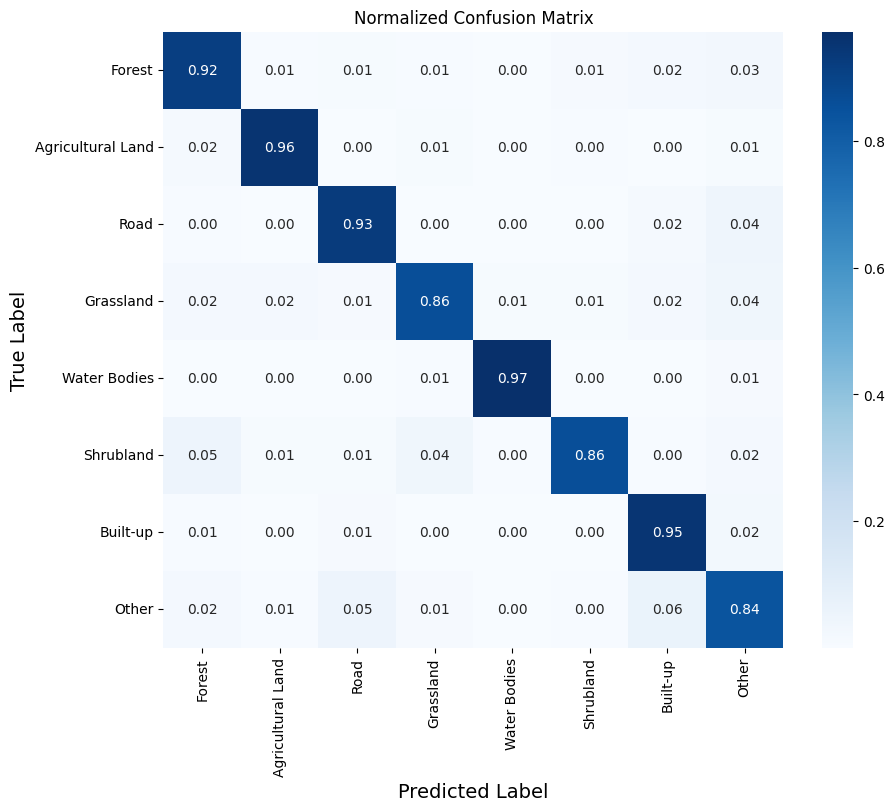

Classification Report:
                   precision    recall  f1-score   support

           Forest       0.92      0.92      0.92  59557514
Agricultural Land       0.94      0.96      0.95  29573828
             Road       0.92      0.93      0.93  93057590
        Grassland       0.88      0.86      0.87  28626832
     Water Bodies       0.97      0.97      0.97  26349920
        Shrubland       0.91      0.86      0.88  19195842
         Built-up       0.93      0.95      0.94 124871192
            Other       0.87      0.84      0.85  83941810

         accuracy                           0.91 465174528
        macro avg       0.92      0.91      0.91 465174528
     weighted avg       0.91      0.91      0.91 465174528

Confusion Matrix:
[[ 54597152    414398    623417    318506    123633    702011   1159665
    1618732]
 [   495720  28261391     30366    295144      1176    133443     87739
     268849]
 [   369261     24901  86521660    331493     44797     19690   1734193
    40

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report

def calculate_iou(y_true, y_pred, num_classes):
    iou = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        if union == 0:  # Skip classes with no ground truth
            continue
        iou.append(intersection / union)
    return iou, np.nanmean(iou) if iou else (iou, np.nan)

def calculate_dice(y_true, y_pred, num_classes):
    dice = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        if true_cls.sum() + pred_cls.sum() == 0:  # Skip classes with no ground truth
            continue
        dice.append(2 * intersection / (true_cls.sum() + pred_cls.sum()))
    return dice, np.nanmean(dice) if dice else (dice, np.nan)

def calculate_pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Initialize arrays to store predictions and true labels
all_preds = []
all_true = []

# Loop through the test generator to collect predictions and ground truths
for i in range(total_steps):
    batch = test_generator[i]
    imgs, masks = batch[0], batch[1]  # Assuming the generator returns (images, masks)

    preds = model.predict(imgs)
    preds = preds.argmax(axis=-1)  # Convert probabilities to class indices
    masks = masks.argmax(axis=-1)  # Convert one-hot masks to class indices

    all_preds.append(preds)
    all_true.append(masks)

# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_true = np.concatenate(all_true, axis=0)

# Calculate IoU and mIoU
num_classes = 8
iou, miou = calculate_iou(all_true, all_preds, num_classes)
print(f"IoU per class: {iou}")
print(f"mIoU: {miou}")

# Calculate Dice Coefficient
dice, mean_dice = calculate_dice(all_true, all_preds, num_classes)
print(f"Dice Coefficient per class: {dice}")
print(f"Mean Dice Coefficient: {mean_dice}")

# Calculate Pixel Accuracy
pixel_accuracy = calculate_pixel_accuracy(all_true, all_preds)
print(f"Pixel Accuracy: {pixel_accuracy}")

# Flatten arrays for sklearn metrics
y_true_flat = all_true.flatten()
y_pred_flat = all_preds.flatten()

# Calculate F1, Recall, and Precision (weighted)
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
precision = precision_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

# Confusion Matrix and Classification Report
class_labels = ['Forest', 'Agricultural Land', 'Road', 'Grassland',
                'Water Bodies', 'Shrubland', 'Built-up', 'Other']

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized)  # Handle NaN values

# Display Confusion Matrix as Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels, fmt='.2f', cbar=True)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat, target_names=class_labels))

# Confusion Matrix (Raw Numbers)
print("Confusion Matrix:")
print(conf_matrix)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

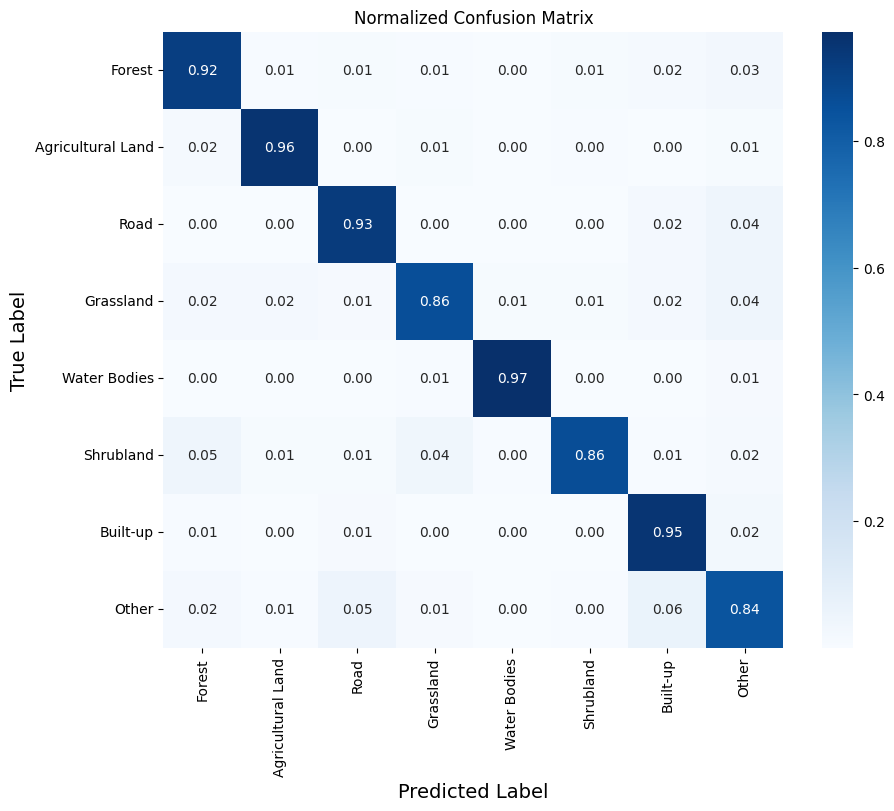

Classification Report:
                   precision    recall  f1-score   support

           Forest       0.92      0.92      0.92  59557514
Agricultural Land       0.94      0.96      0.95  29573828
             Road       0.92      0.93      0.93  93057590
        Grassland       0.89      0.86      0.87  28626832
     Water Bodies       0.97      0.97      0.97  26349920
        Shrubland       0.91      0.86      0.89  19195842
         Built-up       0.93      0.95      0.94 124871192
            Other       0.87      0.84      0.85  83941810

         accuracy                           0.91 465174528
        macro avg       0.92      0.91      0.91 465174528
     weighted avg       0.91      0.91      0.91 465174528

Confusion Matrix:
[[ 54698888    417445    614029    307671    115470    654419   1113894
    1635698]
 [   499912  28254508     39004    302708      1054    127562     83342
     265738]
 [   356137     24972  86568139    317873     34194     20575   1774231
    39

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report

def calculate_iou(y_true, y_pred, num_classes):
    iou = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        if union == 0:  # Skip classes with no ground truth
            continue
        iou.append(intersection / union)
    return iou, np.nanmean(iou) if iou else (iou, np.nan)

def calculate_dice(y_true, y_pred, num_classes):
    dice = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        if true_cls.sum() + pred_cls.sum() == 0:  # Skip classes with no ground truth
            continue
        dice.append(2 * intersection / (true_cls.sum() + pred_cls.sum()))
    return dice, np.nanmean(dice) if dice else (dice, np.nan)

def calculate_pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Initialize arrays to store predictions and true labels
all_preds = []
all_true = []

# Loop through the test generator to collect predictions and ground truths
for i in range(total_steps):
    batch = test_generator[i]
    imgs, masks = batch[0], batch[1]  # Assuming the generator returns (images, masks)

    preds = model.predict(imgs)
    preds = preds.argmax(axis=-1)  # Convert probabilities to class indices
    masks = masks.argmax(axis=-1)  # Convert one-hot masks to class indices

    all_preds.append(preds)
    all_true.append(masks)

# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_true = np.concatenate(all_true, axis=0)

# Calculate IoU and mIoU
num_classes = 8
iou, miou = calculate_iou(all_true, all_preds, num_classes)
print(f"IoU per class: {iou}")
print(f"mIoU: {miou}")

# Calculate Dice Coefficient
dice, mean_dice = calculate_dice(all_true, all_preds, num_classes)
print(f"Dice Coefficient per class: {dice}")
print(f"Mean Dice Coefficient: {mean_dice}")

# Calculate Pixel Accuracy
pixel_accuracy = calculate_pixel_accuracy(all_true, all_preds)
print(f"Pixel Accuracy: {pixel_accuracy}")

# Flatten arrays for sklearn metrics
y_true_flat = all_true.flatten()
y_pred_flat = all_preds.flatten()

# Calculate F1, Recall, and Precision (weighted)
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
precision = precision_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

# Confusion Matrix and Classification Report
class_labels = ['Forest', 'Agricultural Land', 'Road', 'Grassland',
                'Water Bodies', 'Shrubland', 'Built-up', 'Other']

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized)  # Handle NaN values

# Display Confusion Matrix as Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels, fmt='.2f', cbar=True)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat, target_names=class_labels))

# Confusion Matrix (Raw Numbers)
print("Confusion Matrix:")
print(conf_matrix)

In [18]:
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score
total_steps = len(val_generator)

def calculate_iou(y_true, y_pred, num_classes):
    iou = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        if union == 0:  # Skip classes with no ground truth
            continue
        iou.append(intersection / union)
    return iou, np.nanmean(iou) if iou else (iou, np.nan)

def calculate_dice(y_true, y_pred, num_classes):
    dice = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        if true_cls.sum() + pred_cls.sum() == 0:  # Skip classes with no ground truth
            continue
        dice.append(2 * intersection / (true_cls.sum() + pred_cls.sum()))
    return dice, np.nanmean(dice) if dice else (dice, np.nan)

def calculate_pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Initialize arrays to store predictions and true labels
all_preds = []
all_true = []

# Ensure the test generator is resettable

# Loop through the test generator to collect predictions and ground truths
for i in range(total_steps):
    # Get the next batch of images and masks from the generator
    batch = val_generator[i]
    imgs, masks = batch[0], batch[1]  # Assuming the generator returns (images, masks)

    preds = model.predict(imgs)  # Predict on the batch
    preds = preds.argmax(axis=-1)  # Convert probabilities to class indices
    masks = masks.argmax(axis=-1)  # Convert one-hot masks to class indices

    all_preds.append(preds)
    all_true.append(masks)


# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_true = np.concatenate(all_true, axis=0)

# Calculate IoU and mIoU
num_classes = 8
iou, miou = calculate_iou(all_true, all_preds, num_classes)
print(f"IoU per class: {iou}")
print(f"mIoU: {miou}")

# Calculate Dice Coefficient
dice, mean_dice = calculate_dice(all_true, all_preds, num_classes)
print(f"Dice Coefficient per class: {dice}")
print(f"Mean Dice Coefficient: {mean_dice}")

# Calculate Pixel Accuracy
pixel_accuracy = calculate_pixel_accuracy(all_true, all_preds)
print(f"Pixel Accuracy: {pixel_accuracy}")

# Flatten arrays for sklearn metrics
y_true_flat = all_true.flatten()
y_pred_flat = all_preds.flatten()

# Calculate F1, Recall, and Precision (weighted)
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
precision = precision_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Color map for visualization
color_map = {
    0: [0, 255, 0],      # Class 0
    1: [165, 42, 42],    # Class 1
    2: [70, 130, 180],   # Class 2
    3: [50, 205, 50],    # Class 3
    4: [0, 0, 255],      # Class 4
    5: [173, 255, 47],   # Class 5
    6: [255, 105, 45],   # Class 6
    7: [0, 0, 0]         # Class 7
}

# Function to apply the color map to predictions
def colorize_predictions(mask, color_map):
    colorized_image = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for cls, color in color_map.items():
        colorized_image[mask == cls] = color
    return colorized_image


# Generate predictions (limit to first 20 images)
num_images_to_predict = 80
predictions = model.predict(test_generator, verbose=1, steps=num_images_to_predict // test_generator.batch_size)
predictions = np.argmax(predictions, axis=-1)  # Decode predictions in advance

# Process and save images
image_count = 0
for i in range(len(test_generator)):
    if image_count >= len(predictions):
        break

    # Get a batch of test data
    images, ground_truth_masks = test_generator[i]

    for j in range(len(images)):
        if image_count >= len(predictions):
            break

        # Original image
        original_image = images[j]

        # Ground truth mask
        ground_truth_mask = ground_truth_masks[j]
        ground_truth_mask = np.argmax(ground_truth_mask, axis=-1)

        # Predicted mask
        predicted_mask = predictions[image_count]

        # Apply color mapping
        colorized_ground_truth = colorize_predictions(ground_truth_mask, color_map)
        colorized_predicted_mask = colorize_predictions(predicted_mask, color_map)

        # Scale original image if normalized
        if original_image.max() <= 1.0:
            original_image = (original_image * 255).astype('uint8')

        # Save predicted mask as PNG
        pred_save_path = os.path.join(save_dir, f"predicted_{image_count + 1}.png")
        plt.imsave(pred_save_path, colorized_predicted_mask)

        # Plot and save visualization
        plt.figure(figsize=(15, 5))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(original_image)
        plt.title("Original Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(colorized_ground_truth)
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(colorized_predicted_mask)
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        image_count += 1

/home/rdadmin/anaconda3/envs/tf-env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step


NameError: name 'save_dir' is not defined

: 

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score
total_steps = len(val_generator)

def calculate_iou(y_true, y_pred, num_classes):
    iou = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        if union == 0:  # Skip classes with no ground truth
            continue
        iou.append(intersection / union)
    return iou, np.nanmean(iou) if iou else (iou, np.nan)

def calculate_dice(y_true, y_pred, num_classes):
    dice = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        if true_cls.sum() + pred_cls.sum() == 0:  # Skip classes with no ground truth
            continue
        dice.append(2 * intersection / (true_cls.sum() + pred_cls.sum()))
    return dice, np.nanmean(dice) if dice else (dice, np.nan)

def calculate_pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Initialize arrays to store predictions and true labels
all_preds = []
all_true = []

# Ensure the test generator is resettable

# Loop through the test generator to collect predictions and ground truths
for i in range(total_steps):
    # Get the next batch of images and masks from the generator
    batch = val_generator[i]
    imgs, masks = batch[0], batch[1]  # Assuming the generator returns (images, masks)

    preds = model.predict(imgs)  # Predict on the batch
    preds = preds.argmax(axis=-1)  # Convert probabilities to class indices
    masks = masks.argmax(axis=-1)  # Convert one-hot masks to class indices

    all_preds.append(preds)
    all_true.append(masks)


# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_true = np.concatenate(all_true, axis=0)

# Calculate IoU and mIoU
num_classes = 8
iou, miou = calculate_iou(all_true, all_preds, num_classes)
print(f"IoU per class: {iou}")
print(f"mIoU: {miou}")

# Calculate Dice Coefficient
dice, mean_dice = calculate_dice(all_true, all_preds, num_classes)
print(f"Dice Coefficient per class: {dice}")
print(f"Mean Dice Coefficient: {mean_dice}")

# Calculate Pixel Accuracy
pixel_accuracy = calculate_pixel_accuracy(all_true, all_preds)
print(f"Pixel Accuracy: {pixel_accuracy}")

# Flatten arrays for sklearn metrics
y_true_flat = all_true.flatten()
y_pred_flat = all_preds.flatten()

# Calculate F1, Recall, and Precision (weighted)
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
precision = precision_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Color map for visualization
color_map = {
    0: [0, 255, 0],      # Class 0
    1: [165, 42, 42],    # Class 1
    2: [70, 130, 180],   # Class 2
    3: [50, 205, 50],    # Class 3
    4: [0, 0, 255],      # Class 4
    5: [173, 255, 47],   # Class 5
    6: [255, 105, 45],   # Class 6
    7: [0, 0, 0]         # Class 7
}

# Function to apply the color map to predictions
def colorize_predictions(mask, color_map):
    colorized_image = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for cls, color in color_map.items():
        colorized_image[mask == cls] = color
    return colorized_image


# Generate predictions (limit to first 20 images)
num_images_to_predict = 100
predictions = model.predict(test_generator, verbose=1, steps=num_images_to_predict // test_generator.batch_size)
predictions = np.argmax(predictions, axis=-1)  # Decode predictions in advance

# Process and save images
image_count = 0
for i in range(len(test_generator)):
    if image_count >= len(predictions):
        break

    # Get a batch of test data
    images, ground_truth_masks = test_generator[i]

    for j in range(len(images)):
        if image_count >= len(predictions):
            break

        # Original image
        original_image = images[j]

        # Ground truth mask
        ground_truth_mask = ground_truth_masks[j]
        ground_truth_mask = np.argmax(ground_truth_mask, axis=-1)

        # Predicted mask
        predicted_mask = predictions[image_count]

        # Apply color mapping
        colorized_ground_truth = colorize_predictions(ground_truth_mask, color_map)
        colorized_predicted_mask = colorize_predictions(predicted_mask, color_map)

        # Scale original image if normalized
        if original_image.max() <= 1.0:
            original_image = (original_image * 255).astype('uint8')

   

        # Plot and save visualization
        plt.figure(figsize=(15, 5))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(original_image)
        plt.title("Original Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(colorized_ground_truth)
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(colorized_predicted_mask)
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        image_count += 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report

def calculate_iou(y_true, y_pred, num_classes):
    iou = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        if union == 0:  # Skip classes with no ground truth
            continue
        iou.append(intersection / union)
    return iou, np.nanmean(iou) if iou else (iou, np.nan)

def calculate_dice(y_true, y_pred, num_classes):
    dice = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        if true_cls.sum() + pred_cls.sum() == 0:  # Skip classes with no ground truth
            continue
        dice.append(2 * intersection / (true_cls.sum() + pred_cls.sum()))
    return dice, np.nanmean(dice) if dice else (dice, np.nan)

def calculate_pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Initialize arrays to store predictions and true labels
all_preds = []
all_true = []

# Loop through the test generator to collect predictions and ground truths
for i in range(total_steps):
    batch = val_generator[i]
    imgs, masks = batch[0], batch[1]  # Assuming the generator returns (images, masks)

    preds = model.predict(imgs)
    preds = preds.argmax(axis=-1)  # Convert probabilities to class indices
    masks = masks.argmax(axis=-1)  # Convert one-hot masks to class indices

    all_preds.append(preds)
    all_true.append(masks)

# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_true = np.concatenate(all_true, axis=0)

# Calculate IoU and mIoU
num_classes = 8
iou, miou = calculate_iou(all_true, all_preds, num_classes)
print(f"IoU per class: {iou}")
print(f"mIoU: {miou}")

# Calculate Dice Coefficient
dice, mean_dice = calculate_dice(all_true, all_preds, num_classes)
print(f"Dice Coefficient per class: {dice}")
print(f"Mean Dice Coefficient: {mean_dice}")

# Calculate Pixel Accuracy
pixel_accuracy = calculate_pixel_accuracy(all_true, all_preds)
print(f"Pixel Accuracy: {pixel_accuracy}")

# Flatten arrays for sklearn metrics
y_true_flat = all_true.flatten()
y_pred_flat = all_preds.flatten()

# Calculate F1, Recall, and Precision (weighted)
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
precision = precision_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

# Confusion Matrix and Classification Report
class_labels = ['Forest', 'Agricultural Land', 'Road', 'Grassland',
                'Water Bodies', 'Shrubland', 'Built-up', 'Other']

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized)  # Handle NaN values

# Display Confusion Matrix as Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels, fmt='.2f', cbar=True)
plt.title('')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat, target_names=class_labels))

# Confusion Matrix (Raw Numbers)
print("Confusion Matrix:")
print(conf_matrix)